In [ ]:
# Basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import matplotlib.gridspec as gridspec

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from models import vae, cvae


In [2]:
dataset_path = '/Users/lilitasminian/Desktop/DL_project/dataset/Art_Images'

In [3]:
# Checks if a file is a valid image
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image detected and skipped: {file_path}")
        return False

# Collect valid image paths
valid_image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        if is_valid_image(file_path):
            valid_image_paths.append(file_path)

print(f"Number of valid images: {len(valid_image_paths)}")

Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/.DS_Store
Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/training_set/.DS_Store
Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/validation_set/.DS_Store
Number of valid images: 6268


In [4]:
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format

        if self.transform:
            image = self.transform(image)

        return image


In [10]:
hparams = {
    "latent_size": 32,              # Latent dimension size
    "input_size": (3, 64, 64),      # Input size (C, H, W)
    "batch_size": 32,               # Batch size
    "num_epochs": 20,               # Number of epochs
    "learning_rate": 1e-4,          # Learning rate
    "beta": 1.0,                    # KL weight (start with 1, adjust gradually)
    "use_bce": True,                # Use Binary Cross Entropy for reconstruction loss
}

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((64, 64), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))  # Normalize to [0, 1]
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))  # Normalize to [0, 1]
])


# Total dataset with transforms (apply training transform for now)
dataset = ImageDataset(valid_image_paths, transform=train_transform)

In [12]:
from torch.utils.data import random_split, DataLoader

# Define sizes for training, validation, and testing splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply correct transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 5014, Validation samples: 626, Testing samples: 628


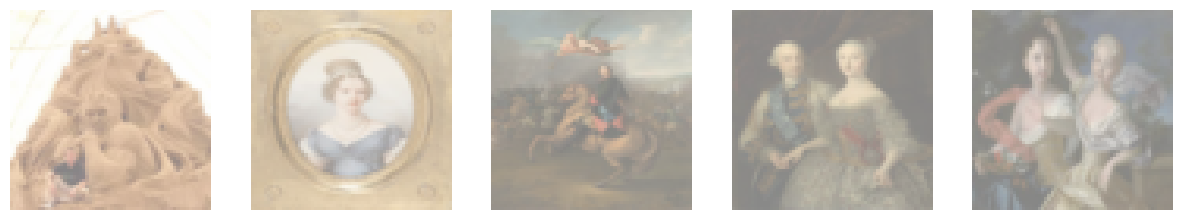

In [13]:
# Display the first few images in the batch
images = next(iter(train_loader))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].permute(1, 2, 0)  # Rearrange to (H, W, C)
    img = (img * 0.5 + 0.5).clamp(0, 1)  # Denormalize if normalized earlier
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

# Training vae

In [14]:

from torch.optim import Adam

def train_vae(model, train_loader, val_loader, hparams):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=hparams["learning_rate"], weight_decay=1e-5)
    training_losses, validation_losses = [], []

    for epoch in range(hparams["num_epochs"]):
        # Adjust beta based on epoch
        beta = min(1.0, epoch / 10) * hparams["beta"]  # Gradually increase beta up to hparams["beta"]
        
        # Training phase
        model.train()
        total_train_loss = 0
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{hparams['num_epochs']}")

        for batch_idx, images in train_progress:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass
            reconstructed, mu, logvar = model(images)

            # Compute losses
            if hparams.get("use_bce", False):
                reconstruction_loss = F.binary_cross_entropy(reconstructed, images, reduction='sum')
            else:
                reconstruction_loss = F.mse_loss(reconstructed, images, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + beta * kl_divergence
            total_train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_progress.set_postfix(batch_loss=loss.item(), avg_loss=total_train_loss / ((batch_idx + 1) * images.size(0)))

        training_losses.append(total_train_loss / len(train_loader.dataset))

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                reconstructed, mu, logvar = model(images)
                if hparams.get("use_bce", False):
                    reconstruction_loss = F.binary_cross_entropy(reconstructed, images, reduction='sum')
                else:
                    reconstruction_loss = F.mse_loss(reconstructed, images, reduction='sum')
                kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                val_loss = reconstruction_loss + beta * kl_divergence
                total_val_loss += val_loss.item()
        validation_losses.append(total_val_loss / len(val_loader.dataset))

        print(f"Epoch [{epoch+1}/{hparams['num_epochs']}], "
              f"Training Loss: {training_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}, Beta: {beta:.2f}")

    return training_losses, validation_losses

Epoch 1/20:  69%|██████▉   | 109/157 [00:14<00:06,  7.95it/s, avg_loss=8.14e+3, batch_loss=2.47e+5]/Users/lilitasminian/Desktop/DL_project/vae/lib/python3.9/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/20: 100%|██████████| 157/157 [00:20<00:00,  7.57it/s, avg_loss=1.16e+4, batch_loss=1.64e+5]


Epoch [1/20], Training Loss: 7962.6938, Validation Loss: 7411.5914, Beta: 0.00


Epoch 2/20: 100%|██████████| 157/157 [00:19<00:00,  7.99it/s, avg_loss=1.08e+4, batch_loss=1.56e+5]


Epoch [2/20], Training Loss: 7424.7481, Validation Loss: 7325.1155, Beta: 0.10


Epoch 3/20: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, avg_loss=1.07e+4, batch_loss=1.73e+5]


Epoch [3/20], Training Loss: 7382.4432, Validation Loss: 7288.9000, Beta: 0.20


Epoch 4/20: 100%|██████████| 157/157 [00:20<00:00,  7.74it/s, avg_loss=1.07e+4, batch_loss=1.64e+5]


Epoch [4/20], Training Loss: 7361.3243, Validation Loss: 7262.1021, Beta: 0.30


Epoch 5/20: 100%|██████████| 157/157 [00:20<00:00,  7.68it/s, avg_loss=1.06e+4, batch_loss=1.68e+5]


Epoch [5/20], Training Loss: 7298.2312, Validation Loss: 7198.7647, Beta: 0.40


Epoch 6/20: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, avg_loss=1.06e+4, batch_loss=1.56e+5]


Epoch [6/20], Training Loss: 7273.9311, Validation Loss: 7188.8210, Beta: 0.50


Epoch 7/20: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, avg_loss=1.05e+4, batch_loss=1.57e+5]


Epoch [7/20], Training Loss: 7255.4774, Validation Loss: 7186.9069, Beta: 0.60


Epoch 8/20: 100%|██████████| 157/157 [00:19<00:00,  7.89it/s, avg_loss=1.05e+4, batch_loss=1.54e+5]


Epoch [8/20], Training Loss: 7250.9442, Validation Loss: 7193.7178, Beta: 0.70


Epoch 9/20: 100%|██████████| 157/157 [00:19<00:00,  7.87it/s, avg_loss=1.05e+4, batch_loss=1.64e+5]


Epoch [9/20], Training Loss: 7244.0450, Validation Loss: 7153.1862, Beta: 0.80


Epoch 10/20: 100%|██████████| 157/157 [00:19<00:00,  8.04it/s, avg_loss=1.05e+4, batch_loss=1.63e+5]


Epoch [10/20], Training Loss: 7216.1583, Validation Loss: 7112.5608, Beta: 0.90


Epoch 11/20: 100%|██████████| 157/157 [00:19<00:00,  7.89it/s, avg_loss=1.04e+4, batch_loss=1.56e+5]


Epoch [11/20], Training Loss: 7193.0085, Validation Loss: 7107.8671, Beta: 1.00


Epoch 12/20: 100%|██████████| 157/157 [00:21<00:00,  7.29it/s, avg_loss=1.04e+4, batch_loss=1.58e+5]


Epoch [12/20], Training Loss: 7172.5528, Validation Loss: 7082.2537, Beta: 1.00


Epoch 13/20: 100%|██████████| 157/157 [00:19<00:00,  8.02it/s, avg_loss=1.04e+4, batch_loss=1.63e+5]


Epoch [13/20], Training Loss: 7166.3101, Validation Loss: 7069.9541, Beta: 1.00


Epoch 14/20: 100%|██████████| 157/157 [00:20<00:00,  7.68it/s, avg_loss=1.04e+4, batch_loss=1.57e+5]


Epoch [14/20], Training Loss: 7161.3559, Validation Loss: 7065.6355, Beta: 1.00


Epoch 15/20: 100%|██████████| 157/157 [00:20<00:00,  7.66it/s, avg_loss=1.04e+4, batch_loss=1.7e+5] 


Epoch [15/20], Training Loss: 7155.6102, Validation Loss: 7062.0687, Beta: 1.00


Epoch 16/20: 100%|██████████| 157/157 [00:20<00:00,  7.78it/s, avg_loss=1.04e+4, batch_loss=1.61e+5]


Epoch [16/20], Training Loss: 7141.5656, Validation Loss: 7110.3180, Beta: 1.00


Epoch 17/20: 100%|██████████| 157/157 [00:20<00:00,  7.73it/s, avg_loss=1.04e+4, batch_loss=1.58e+5]


Epoch [17/20], Training Loss: 7133.5341, Validation Loss: 7106.1891, Beta: 1.00


Epoch 18/20: 100%|██████████| 157/157 [00:19<00:00,  8.07it/s, avg_loss=1.04e+4, batch_loss=1.64e+5]


Epoch [18/20], Training Loss: 7131.6848, Validation Loss: 7119.1573, Beta: 1.00


Epoch 19/20: 100%|██████████| 157/157 [00:19<00:00,  8.06it/s, avg_loss=1.03e+4, batch_loss=1.59e+5]


Epoch [19/20], Training Loss: 7121.8503, Validation Loss: 7054.8288, Beta: 1.00


Epoch 20/20: 100%|██████████| 157/157 [00:19<00:00,  8.05it/s, avg_loss=1.03e+4, batch_loss=1.58e+5]


Epoch [20/20], Training Loss: 7123.5726, Validation Loss: 7147.3303, Beta: 1.00


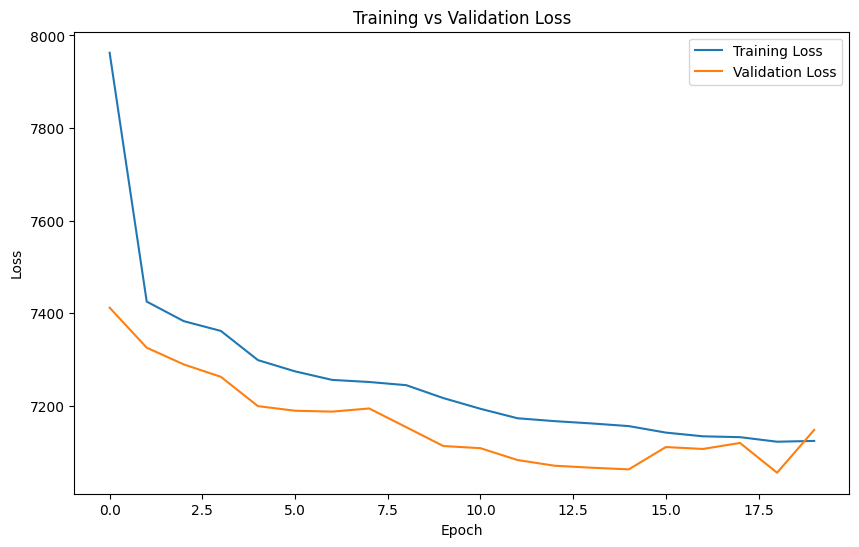

In [15]:
from models.vae import VAE

vae = VAE(input_size=hparams["input_size"], latent_size=hparams["latent_size"])

# Train the VAE
training_losses, validation_losses = train_vae(vae, train_loader, val_loader, hparams)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()